In [ ]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv
%matplotlib inline
import glob
from IPython.display import Image
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping

# Shared Input Layer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate

import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt

import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image


from google.colab import drive
drive.mount('/content/drive')
tf.test.gpu_device_name()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


''

In [ ]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    dummies = pd.get_dummies(df[target])
    return df[result].values.astype(np.float32), dummies.values.astype(np.float32)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

path = "./drive/"

filename = os.path.join(path,"My Drive/IRIS.csv")
df = pd.read_csv(filename)
# df = df.drop(columns=['Unnamed: 32', 'id'])

df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
print(df[40:70])

    sepal_length  sepal_width  petal_length  petal_width          species
40           5.0          3.5           1.3          0.3      Iris-setosa
41           4.5          2.3           1.3          0.3      Iris-setosa
42           4.4          3.2           1.3          0.2      Iris-setosa
43           5.0          3.5           1.6          0.6      Iris-setosa
44           5.1          3.8           1.9          0.4      Iris-setosa
45           4.8          3.0           1.4          0.3      Iris-setosa
46           5.1          3.8           1.6          0.2      Iris-setosa
47           4.6          3.2           1.4          0.2      Iris-setosa
48           5.3          3.7           1.5          0.2      Iris-setosa
49           5.0          3.3           1.4          0.2      Iris-setosa
50           7.0          3.2           4.7          1.4  Iris-versicolor
51           6.4          3.2           4.5          1.5  Iris-versicolor
52           6.9          3.1         

In [ ]:
x,y = to_xy(df,"species")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=30)
print(x_train[0])
print(y_train[0])
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

[5.2 2.7 3.9 1.4]
[0. 1. 0.]
(105, 4)
(105, 3)
(45, 4)
(45, 3)


In [ ]:
model = Sequential()
model.add(Dense(10, input_dim=x_train.shape[1], activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(y_train.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 10)                50        
_________________________________________________________________
dense_93 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_94 (Dense)             (None, 5)                 45        
_________________________________________________________________
dense_95 (Dense)             (None, 3)                 18        
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=25, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test), verbose=2,callbacks=[monitor], epochs=100, batch_size=5)

Epoch 1/100
21/21 - 0s - loss: 1.1845 - val_loss: 1.1111
Epoch 2/100
21/21 - 0s - loss: 1.1610 - val_loss: 1.1011
Epoch 3/100
21/21 - 0s - loss: 1.1431 - val_loss: 1.0958
Epoch 4/100
21/21 - 0s - loss: 1.1276 - val_loss: 1.0902
Epoch 5/100
21/21 - 0s - loss: 1.1170 - val_loss: 1.0888
Epoch 6/100
21/21 - 0s - loss: 1.1071 - val_loss: 1.0858
Epoch 7/100
21/21 - 0s - loss: 1.1003 - val_loss: 1.0850
Epoch 8/100
21/21 - 0s - loss: 1.0959 - val_loss: 1.0845
Epoch 9/100
21/21 - 0s - loss: 1.0892 - val_loss: 1.0841
Epoch 10/100
21/21 - 0s - loss: 1.0837 - val_loss: 1.0819
Epoch 11/100
21/21 - 0s - loss: 1.0799 - val_loss: 1.0807
Epoch 12/100
21/21 - 0s - loss: 1.0750 - val_loss: 1.0781
Epoch 13/100
21/21 - 0s - loss: 1.0711 - val_loss: 1.0756
Epoch 14/100
21/21 - 0s - loss: 1.0656 - val_loss: 1.0720
Epoch 15/100
21/21 - 0s - loss: 1.0605 - val_loss: 1.0687
Epoch 16/100
21/21 - 0s - loss: 1.0543 - val_loss: 1.0625
Epoch 17/100
21/21 - 0s - loss: 1.0471 - val_loss: 1.0584
Epoch 18/100
21/21 - 0s

In [ ]:
pred = model.predict(x_test)
# Measure accuracy
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9777777777777777


[[13  0  0]
 [ 0 13  0]
 [ 0  1 18]]
Ploting confusion matrix


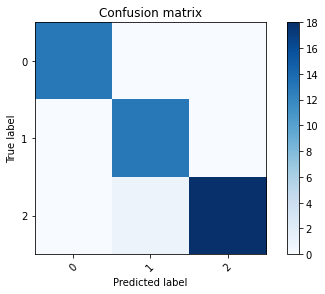

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.93      1.00      0.96        13
           2       1.00      0.95      0.97        19

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



In [ ]:
import numpy as np

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report
species = encode_text_index(df,"species")

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, species)
plt.show()


print(classification_report(y_true, pred))